In [1]:
import itertools as it
import random

from collections import Counter, defaultdict

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
def to_freq_df(df, pairs: list[tuple[int, int]]):
    indices = sorted([i for i, _ in pairs] + [j for _, j in pairs])
    return df.iloc[indices]

In [4]:
# Sample Stat 1: Threshold on absolute difference between the members of each pair
def sample_tol(df, *, cols: list[str], ratio: float) -> list[tuple[int, int]]:
    pairs = []
    tols = [np.std(df[col]) * ratio for col in cols]
    for i, j in it.combinations(list(range(len(df))), 2):
        for col, tol in zip(cols, tols):
            if np.abs(df.iloc[i][col] - df.iloc[j][col]) >= tol:
                break
        else:
            pairs.append((i, j))
    random.shuffle(pairs)
    return pairs

In [5]:
def sample_cohorts(df, *, col: str, n_bins: int) -> list[tuple[int, int]]:
    values = np.array(df[col])
    indices = np.arange(len(values))
    hist, bin_edges = np.histogram(values, bins=n_bins)
    print(np.mean([b - a for a, b in it.pairwise(bin_edges)]))
    probs = hist / hist.sum()
    bins = np.digitize(values, bin_edges[1:-1])
    # Calculate cohorts
    cohorts = {}
    for i in range(n_bins):
        pairs = list(it.combinations(indices[bins == i], 2))
        if len(pairs) > 0:
            random.shuffle(pairs)
            cohorts[i] = pairs
    # for i, pairs in cohorts.items():
    #     print(f"bin {i}: {len(pairs)} pairs")
    # Calculate pairs
    pairs = []
    while True:
        i = np.random.choice(n_bins, p=probs)
        if i not in cohorts:
            continue
        if len(cohorts[i]) > 0:
            pairs.append(cohorts[i].pop())
            continue
        del cohorts[i]
        if len(cohorts) == 0:
            break
    return pairs

In [6]:
def sample_neighbor(df, *, col: str, ratio: float) -> list[tuple[int, int]]:
    tol = np.std(df[col]) * ratio
    print(tol)
    neighbors = defaultdict(list)
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if np.abs(df.iloc[i][col] - df.iloc[j][col]) < tol:
                neighbors[i].append(j)
                neighbors[j].append(i)
    for neighbor_list in neighbors.values():
        random.shuffle(neighbor_list)
    pairs = []
    while True:
        i = np.random.choice(list(neighbors.keys()))
        j = neighbors[i].pop()
        neighbors[j].remove(i)
        pairs.append((i, j))
        if len(neighbors[i]) == 0:
            del neighbors[i]
        if len(neighbors[j]) == 0:
            del neighbors[j]
        if len(neighbors) == 0:
            break
    return pairs

In [7]:
def sample_neighbor2(df, *, col: str, ratio: float) -> list[tuple[int, int]]:
    tol = np.std(df[col]) * ratio
    print(tol)
    neighbors = defaultdict(list)
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if np.abs(df.iloc[i][col] - df.iloc[j][col]) < tol:
                neighbors[i].append(j)
                neighbors[j].append(i)
    for neighbor_list in neighbors.values():
        random.shuffle(neighbor_list)
    pairs = []
    indices = []
    while True:
        print(neighbors)
        if len(indices) == 0:
            indices = list(range(len(df)))
            random.shuffle(indices)
        i = indices.pop()
        if i not in neighbors:
            continue
        j = neighbors[i].pop()
        neighbors[j].remove(i)
        pairs.append((i, j))
        if len(neighbors[i]) == 0:
            del neighbors[i]
        if len(neighbors[j]) == 0:
            del neighbors[j]
        if len(neighbors) == 0:
            break
    return pairs

In [8]:
def sample_custom2(df, *, col: str, ratio: float, rounds: int) -> list[tuple[int, int]]:
    pairs = []
    tol = np.std(df[col]) * ratio
    possible_pairs = list(it.combinations(range(len(df)), 2))
    for _ in range(rounds):
        indices = set(range(len(df)))
        random.shuffle(possible_pairs)
        for i, j in possible_pairs:
            if (i not in indices) or (j not in indices):
                continue
            if np.abs(df.iloc[i][col] - df.iloc[j][col]) >= tol:
                continue
            if (i, j) in pairs:
                continue
            pairs.append((i, j))
            indices.remove(i)
            indices.remove(j)
    return pairs

In [9]:
def plot_sampling_loc(df, pairs):
    freq_df = to_freq_df(df, pairs[:len(df)])
    real = list(df["loc"])
    sampling = list(freq_df["loc"])
    plot = sns.histplot(data={"real": real, "sampling": sampling}, multiple="layer")
    plot.set_xlabel("LOC")
    plot.set_ylabel("# of Files")
    return plot

In [10]:
def plot_sampling_file_counts(df, pairs):
    pairs = pairs[:len(df)]
    counts = np.array(list(Counter([a for a, _ in pairs] + [b for _, b in pairs]).values()))
    # counts = counts / (len(pairs) / len(df))
    print(np.mean(counts))
    return sns.boxplot(x=counts)

In [11]:
def load_student_df():
    return pd.concat([
        pd.read_csv("svc2_survey1.csv"), 
        pd.read_csv("svc2_survey2.csv"), 
        pd.read_csv("svc2_survey3.csv"), 
        pd.read_csv("svc2_survey5.csv"), 
        pd.read_csv("svc2_survey6.csv"), 
        pd.read_csv("svc2_survey7.csv")
    ], ignore_index=True)

df1 = pd.read_csv("svc2_depends.csv")
df1.insert(0, "project", "depends")
df2 = load_student_df()
df2.insert(0, "project", "survey")
df = pd.concat([df1, df2], ignore_index=True)
df1 = df[df["project"] == "depends"]
df2 = df[df["project"] == "survey"]

df

project                                           filename  loc  \
0    depends            src/main/java/depends/LangRegister.java   51   
1    depends                    src/main/java/depends/Main.java  204   
2    depends      src/main/java/depends/ParameterException.java   11   
3    depends  src/main/java/depends/deptypes/DependencyType....   76   
4    depends      src/main/java/depends/entity/AliasEntity.java  204   
..       ...                                                ...  ...   
322   survey                     src/main/java/TakenSurvey.java   22   
323   survey                       src/main/java/TestPanel.java  116   
324   survey                    src/main/java/TestResponse.java   54   
325   survey               src/main/java/TrueFalseQuestion.java   37   
326   survey                      src/main/java/Validation.java   31   

     entities                                            content  
0           3  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
1           5  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
2           2  package depends;\n\npublic class ParameterExce...  
3          21  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
4          28  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
..        ...                                                ...  
322         4  import javax.swing.*;\r\n\r\npublic class Take...  
323         3  import javax.swing.*;\r\nimport java.awt.*;\r\...  
324        15  import java.io.File;\r\nimport java.util.List;...  
325         7  import javax.swing.*;\r\nimport java.io.*;\r\n...  
326         2  public class Validation {\r\n    /**\r\n     *...  

[327 rows x 5 columns]

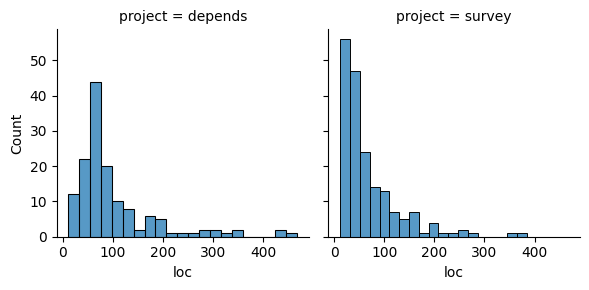

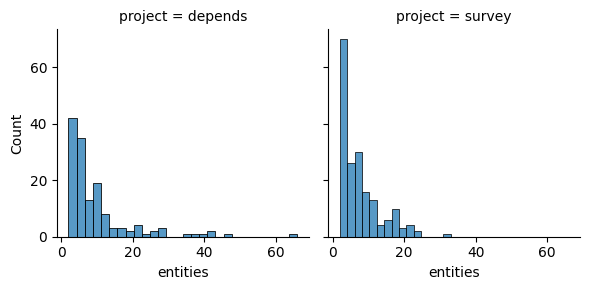

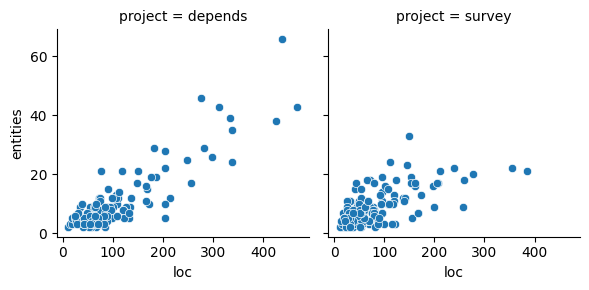

In [12]:
display(sns.FacetGrid(df, col="project").map(sns.histplot, "loc"))
display(sns.FacetGrid(df, col="project").map(sns.histplot, "entities"))
display(sns.FacetGrid(df, col="project").map(sns.scatterplot, "loc", "entities"))

Text(0.5, 1.0, 'Sampling Strategy 1')

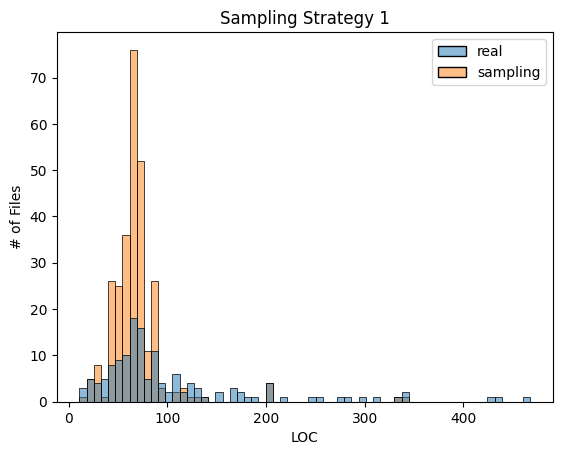

In [34]:
# pairs1 = sample_tol(df1, cols=["loc", "entities"], ratio=1/8)
pairs = sample_tol(df1, cols=["loc"], ratio=1/16)
plot_sampling_loc(df1, pairs).set_title("Sampling Strategy 1")

2.6296296296296298


<Axes: >

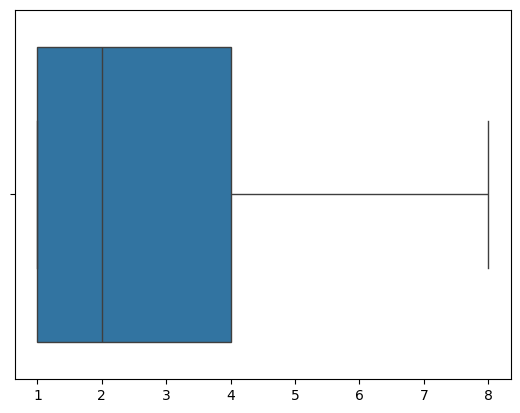

In [14]:
plot_sampling_file_counts(df1, pairs)

14.28125
# of Pairs: 986


<Axes: xlabel='LOC', ylabel='# of Files'>

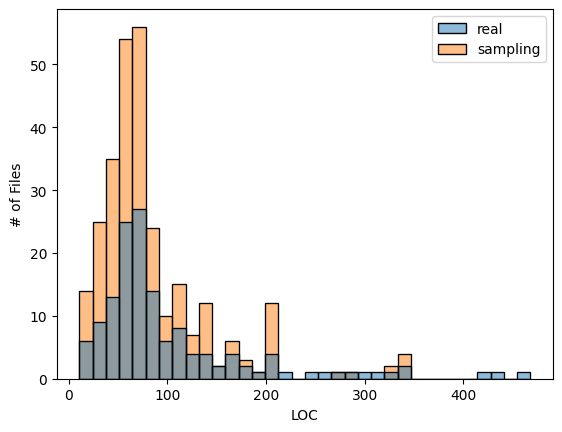

In [15]:
pairs = sample_cohorts(df1, col="loc", n_bins=32)
print(f"# of Pairs: {len(pairs)}")
display(plot_sampling_loc(df1, pairs))

2.3666666666666667


<Axes: >

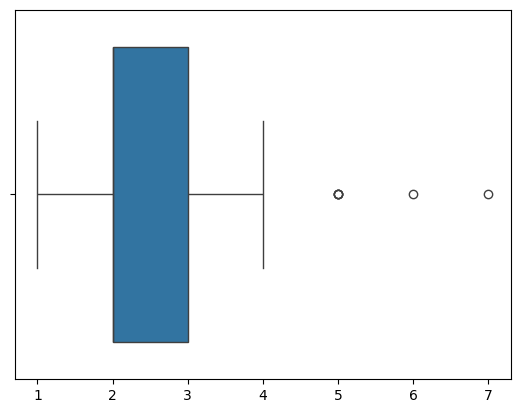

In [16]:
display(plot_sampling_file_counts(df1, pairs))

In [35]:
df1

project                                           filename  loc  \
0    depends            src/main/java/depends/LangRegister.java   51   
1    depends                    src/main/java/depends/Main.java  204   
2    depends      src/main/java/depends/ParameterException.java   11   
3    depends  src/main/java/depends/deptypes/DependencyType....   76   
4    depends      src/main/java/depends/entity/AliasEntity.java  204   
..       ...                                                ...  ...   
137  depends  src/main/java/depends/relations/BindingResolve...  298   
138  depends  src/main/java/depends/relations/FunctionMatche...   54   
139  depends  src/main/java/depends/relations/ImportLookupSt...   85   
140  depends      src/main/java/depends/relations/Relation.java   67   
141  depends  src/main/java/depends/relations/RelationCounte...  257   

     entities                                            content  
0           3  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
1           5  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
2           2  package depends;\n\npublic class ParameterExce...  
3          21  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
4          28  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
..        ...                                                ...  
137        26  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
138         3  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
139         9  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
140        10  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  
141        17  /*\nMIT License\n\nCopyright (c) 2018-2019 Gan...  

[142 rows x 5 columns]

3.8535863595530375
# of Pairs: 1185


Text(0.5, 1.0, 'Sampling Strategy 2')

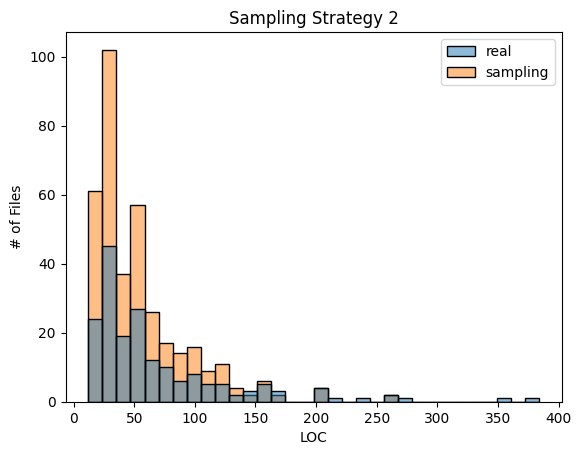

In [36]:
pairs = sample_neighbor(df2, col="loc", ratio=1/16)
print(f"# of Pairs: {len(pairs)}")
plot_sampling_loc(df2, pairs).set_title("Sampling Strategy 2")

2.406779661016949


<Axes: >

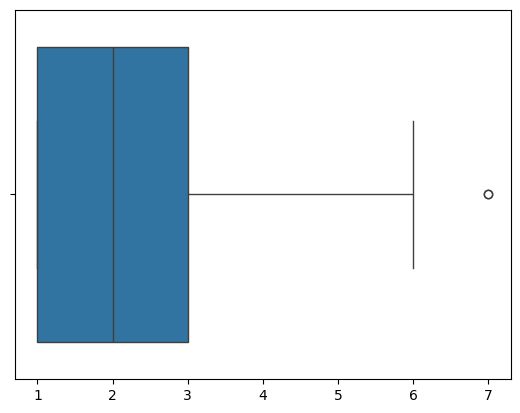

In [18]:
display(plot_sampling_file_counts(df1, pairs))

5.297940376943785
defaultdict(<class 'list'>, {0: [122, 62, 46, 53, 102, 138, 51, 16, 81, 37, 68, 92, 38, 72, 28, 84, 89], 16: [51, 0, 72, 37, 89, 68, 28, 49, 34, 62, 81, 53, 122, 138, 126], 28: [16, 102, 38, 51, 37, 0, 46, 81, 89, 68, 53, 122, 138, 72, 62], 37: [16, 34, 49, 126, 68, 62, 138, 122, 51, 53, 89, 0, 72, 81, 28, 86], 38: [36, 0, 123, 28, 84, 119, 46, 102, 92, 104], 46: [123, 36, 92, 104, 84, 0, 38, 72, 28, 102], 51: [37, 16, 53, 28, 81, 89, 0, 72, 138, 126, 68, 34, 122, 62, 49], 53: [34, 81, 62, 51, 37, 68, 72, 28, 126, 49, 138, 16, 89, 122, 0], 62: [16, 89, 0, 37, 81, 72, 138, 126, 28, 122, 34, 53, 51, 68, 49], 68: [49, 28, 138, 53, 89, 86, 62, 16, 37, 81, 34, 0, 122, 51, 72, 126], 72: [102, 0, 28, 68, 51, 138, 89, 46, 62, 122, 81, 37, 16, 53, 34], 81: [138, 34, 126, 51, 62, 0, 89, 72, 16, 37, 28, 68, 53, 122, 49, 86], 84: [119, 0, 123, 104, 36, 80, 46, 102, 38, 92], 89: [0, 49, 51, 37, 16, 138, 34, 68, 122, 28, 126, 81, 62, 72, 53], 92: [102, 38, 104, 80, 36, 46, 119, 84,

<Axes: xlabel='LOC', ylabel='# of Files'>

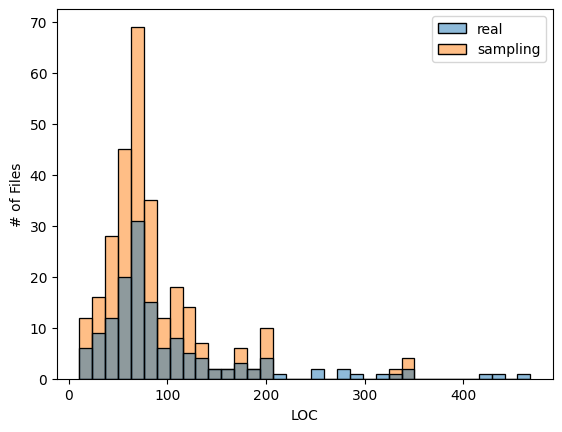

In [19]:
pairs = sample_neighbor2(df1, col="loc", ratio=1/16)
print(f"# of Pairs: {len(pairs)}")
plot_sampling_loc(df1, pairs)

2.1515151515151514


<Axes: >

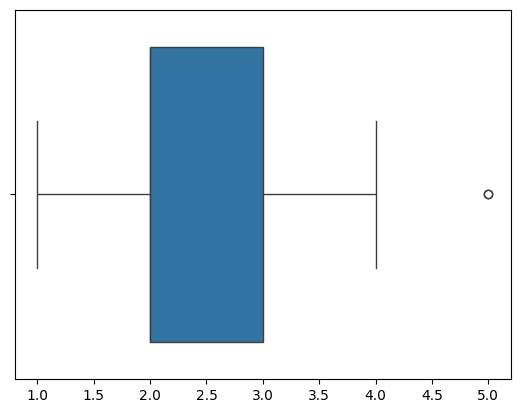

In [20]:
display(plot_sampling_file_counts(df1, pairs))

# of Pairs: 274


<Axes: xlabel='LOC', ylabel='# of Files'>

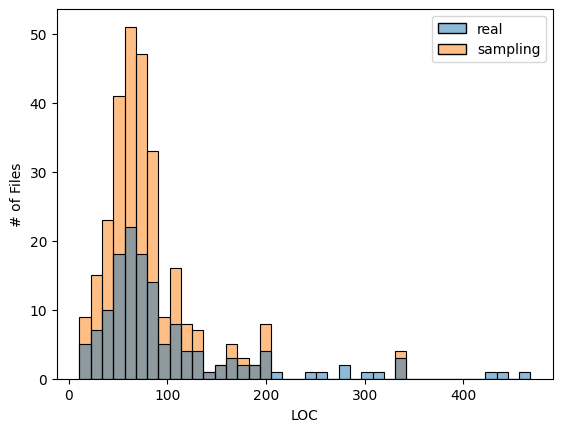

In [21]:
pairs = sample_custom2(df1, col="loc", ratio=1/16, rounds=5)
print(f"# of Pairs: {len(pairs)}")
plot_sampling_loc(df1, pairs)

2.1515151515151514


<Axes: >

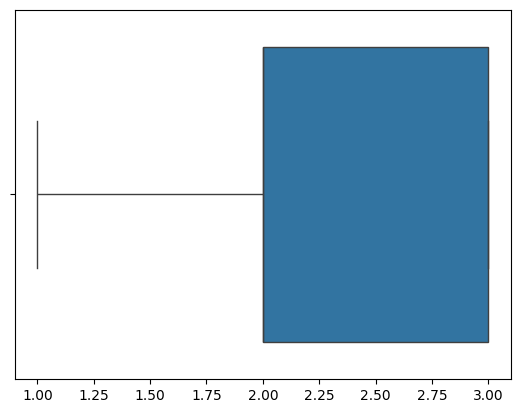

In [22]:
display(plot_sampling_file_counts(df1, pairs))

In [23]:
a, b = pairs[0]
print(df2.iloc[a]["content"])

import java.io.FileWriter;
import java.io.IOException;
import java.util.List;

public class HTMLExportStrategy implements ExportStrategy {
    @Override
    public void export(Form form, String filePath) {
        try (FileWriter writer = new FileWriter(filePath)) {
            writer.append("<html><body>");
            writer.append("<h1>").append(form.getName()).append("</h1>");
            for (Question question : form.getQuestions()) {
                writer.append("<p>").append(question.display()).append("</p>");
            }
            writer.append("</body></html>");
        } catch (IOException e) {
            e.printStackTrace();
        }
    }

    @Override
    public void exportAnswerSheets(List<AnswerSheet> answerSheets, String filePath) {
        try (FileWriter writer = new FileWriter(filePath)) {
            writer.append("<html><body>");
            writer.append("<h1>Answer Sheets</h1>");
            for (int i = 0; i < answerSheets.size(); i++) {
                

In [24]:
print(df2.iloc[b]["content"])

package Menu.MenuOptions;

public class QuitOption extends MenuOption {

    @Override
    public void execute() {
        // Do nothing
    }

    @Override
    public String getOptionName() {
        return "Exit menu.";
    }
}

